## [This notebook has been created for a youtube series - Introduction to Pyspark (click to visit)](https://www.youtube.com/channel/UCHpga4QsQPB9PUpasfyf8cg?sub_confirmation=1)


### Following topics have been covered here:
1. Setting up the environment
2. Loading the dataset into Pyspark
3. Applying Filters
4. Group by and Aggregation
5. Joins  (left, right, inner, full)
6. Partition By & Window Function
7. Automating the code

# Import and Install required packages

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are aavailable in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Setup

In [ ]:
# install pyspark
!pip install pyspark

In [ ]:
# list the files in the present working directory i.e. in which this code is present
!ls

In [ ]:
# print the full path of present working directory
!pwd

In [ ]:
# SparkContext is used to create and initialize Pyspark
from pyspark import SparkContext
# provide the appName
sc = SparkContext(appName='covid19anaysis')
# if something is printed like the version of the Spark; it indicates that the spark successfully initiated
sc

In [ ]:
# we can also run SQL queries with same performance as that of using Pyspark modules/functions
# so to enable such functionalities and to use the pyspark functions we initialize it
from pyspark.sql import SQLContext
# initializing SQLContext
sqlContext = SQLContext(sc)
# to check if it got initialized or not
sqlContext

In [ ]:
# we will use some of the functions present in pyspark like sum, min, max
# we import them using alias and not like - from pyspark.sql.functions import *
# the reason being; there are already functions sum, min, max, etc. present in python and it will override them
import pyspark.sql.functions as F
# this contains the data-types avilable in the pyspark
import pyspark.sql.types as T

# Load the Dataset

In [ ]:
# load the data using pandas
pdf = pd.read_csv('/kaggle/input/us-counties-covid-19-dataset/us-counties.csv')
pdf.head(2)

In [ ]:
# using createDataFrame we can covert pandas dataframe into pyspark
sdf = sqlContext.createDataFrame(pdf)
# similar to head we use show in pyspark
# it takes two inputs; first (int) the number of rows to display and second (boolean) to truncate the data or not
sdf.show(5)

In [ ]:
# as mentioned above we can write SQL queries in pyspark
# and to achieve so, we first have to save its schema into temporary tables (just an alias)
# this creates a table with name 'covid_data'
sdf.registerTempTable('covid_data')

In [ ]:
# to check the schema (columns & their data types)
sdf.printSchema()

In [ ]:
# to print the number of rows in the dataset
sdf.count()

# Filters

In [ ]:
# to get the latest date available in the dataset
# we use agg function to achieve the same
latest_date = sdf.agg(F.max('date').alias('max_data'))
latest_date.show()

In [ ]:
# we can get the same results using the sql queries
latest_date_sql = sqlContext.sql(
    """ SELECT max(date) as max_data FROM covid_data"""
)
latest_date_sql.show()

In [ ]:
# both ways we are returned a spark dataframe
type(latest_date) 

In [ ]:
type(latest_date_sql) 

In [ ]:
# to extract the value we use collect function
# BUT, collect() should be only used on small data sizes as all the data is collected on the master node
# since master nodes don't usually have such memory; it will fail (crash)
latest_date = latest_date.collect()
# the data returned is in the format of lists in lists to be more specific list of namedTuples
# namedTuples are available in collections and we can access the values inside it by providing parameter-name
latest_date

In [ ]:
# there is only single item in the list and we will refer it using index - 0
# also, as mentioned above we can extract values from named tuple using the names of parameters/columns
latest_date = latest_date[0]['max_data']
latest_date

In [ ]:
# so the latest date avilable is 2020-04-13
# now, we fill filter the data where this date is present
sdf_filtered = sdf.where(
    "date = '{}'".format(latest_date)
)

sdf_filtered.show(2)

In [ ]:
# now lets check the number of records in the filtered data
sdf_filtered.count()

In [ ]:
# I will be drawing parallels between the sql and pyspark for easy understanding
# we can achieve the same using SQL and it is as follows
latest_date_sql = sqlContext.sql(
    """ SELECT * FROM covid_data WHERE date = '{}'""".format(latest_date)
)
latest_date_sql.show(10)

In [ ]:
# checking the count of the records
latest_date_sql.count()

# Groupby and Aggregation

## Overall Statistics

In [ ]:
# since we did not mention any grouping level this will return the statistics at overall level
overall_stats = sdf_filtered.agg(
    F.sum("cases").alias("total_cases"), # to sum the values in column 'cases'
    F.sum("deaths").alias("total_deaths"),
    F.count("*").alias("number_of_records"), # to count the number of records in the dataset
    F.countDistinct("county").alias("number_of_counties"), # to get the distinct count of counties in column 'county'
    F.countDistinct("state").alias("number_of_states")
)

overall_stats.show(1, False)

In [ ]:
# sort the data at column-'county' and show top 10 records
sdf_filtered.orderBy("county").show(10, False)

In [ ]:
# register the dataframe as a table
sdf_filtered.registerTempTable("covid19_20200413")

In [ ]:
# achiving the same using SQL queries
sqlContext.sql(
    """
        SElECT
            SUM(cases) as number_of_cases,
            SUM(deaths) as number_of_deaths,
            COUNT(*) as number_of_records,
            COUNT(DISTINCT county) as number_of_counties,
            COUNT(DISTINCT state) as number_of_states
        FROM
            covid19_20200413
    """
).show(1, False)

## Summary at County level

In [ ]:
# here, we are grouping the data at 'county' level and this will take sum of cases, states and others
# and summarize it at 'county' level 
county_summary = sdf_filtered.groupBy(
    "county"
).agg(
    F.sum("cases").alias("total_cases"),
    F.sum("deaths").alias("total_deaths"),
    F.count("*").alias("number_of_records"),
    F.countDistinct("state").alias("number_of_states")
)

# order the county in alphabetical order and show top 20 records
county_summary.orderBy("county").show(20, False)

In [ ]:
# ideally for each county there should be no state with same name
# so, here we are comparing the 'number_of_records' and 'number_of_states'
# and filtering only those records where both does not match
filtered_county_rec = county_summary.where(
    F.col("number_of_records") != F.col("number_of_states")
)

# checking the count of filtered records
# here count is zero - indicating that there are no duplicates
filtered_county_rec.count()

In [ ]:
# so the dataframe returned is empty - containing no rows
filtered_county_rec.show()

In [ ]:
# achieving the same using SQL queries 
sqlContext.sql(
    """
        SElECT
            county,
            SUM(cases) as number_of_cases,
            SUM(deaths) as number_of_deaths,
            COUNT(*) as number_of_records,
            COUNT(DISTINCT state) as number_of_states
        FROM
            covid19_20200413
        GROUP BY
            county
        ORDER BY
            county
    """
).show(10, False)

# Joins

*Source: https://dzone.com/articles/how-to-perform-joins-in-apache-hive

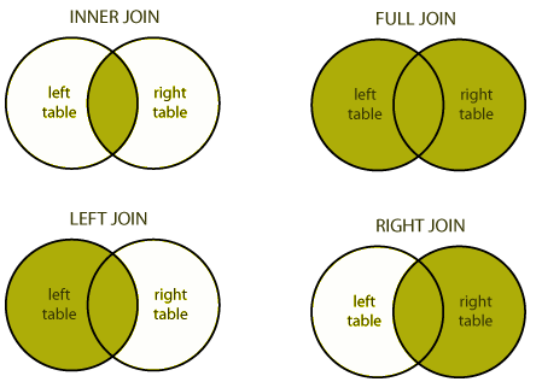

In [ ]:
# filter data for county - Adair & Addison and prepare our left_table
left_table = county_summary.where(
    "county in ('Adair', 'Addison')"
)
left_table.show(5, False)

In [ ]:
# filter data for county - Ada & Accomack and prepare our right_table
right_table = county_summary.where(
    "county in ('Ada', 'Accomack')"
)
right_table.show(5, False)

In [ ]:
# applying inner join
# county_summary contains all the counties and their statistics
inner_table = county_summary.join(
    left_table,
    on=["county"],
    how="inner"
)

inner_table.show(100, False)

In [ ]:
# applying left join
left_table_joined = left_table.join(
    right_table,
    on=["county"],
    how="left"
)

left_table_joined.show(100, False)

In [ ]:
# applying right join
right_table_joined = left_table.join(
    right_table,
    on=["county"],
    how="right"
)

right_table_joined.show(100, False)

In [ ]:
# applying outer join or full join
outer_table_joined = left_table.join(
    right_table,
    on=["county"],
    how="outer"
)

outer_table_joined.show(100, False)

In [ ]:
# get percentage # of cases for each state in Adair
# filter data for county - Adair
adir_overall = county_summary.where(
    "county in ('Adair')"
)
adir_overall.show(5, False)

In [ ]:
# join the Adair summary to its states
perc_cases_statewise = sdf_filtered.join(
    adir_overall,
    on="county",
    how="inner"
)

perc_cases_statewise.show(10, False)

In [ ]:
# calculate percentage of cases and deaths
perc_cases_statewise = perc_cases_statewise.withColumn(
    "perc_cases",
    F.col("cases")/F.col("total_cases")
).withColumn(
    "perc_deaths",
    F.col("deaths")/F.col("total_deaths")
)

perc_cases_statewise.show(10, False)

Note: quick insight here is that though Kentucky has the highest % of cases (47%), it has 50% of the deaths

# Parition By & Window Function

In [ ]:
# this is required to apply parition by clause
from pyspark.sql.window import Window

**We will be giving a rank to the Counties based on the total number of cases they have**

In [ ]:
# let's print out few records to check the structure of the dataframe
county_summary.show(2, False)

In [ ]:
# we will create a new column and store the new dataframe as county_summary_ranked
# withColumn is used to create new columns; where first parameter is the column name and second the values for the column
county_summary_ranked = county_summary.withColumn(
    "rank", # column name
    # rank function assigns a rank starting from 1 and orderBy condition mentions that rank will be based on the column - total_cases
    # by default the sorting is done in ascending order
    F.rank().over(Window.orderBy("total_cases")) 
)

# print out some of the records
county_summary_ranked.show(5, False)

In [ ]:
county_summary_ranked = county_summary_ranked.withColumn(
    "rank_desc",
    # if we want high end values to be assigned the lower rank, we sort the data in descending order using F.desc function
    F.rank().over(Window.orderBy(F.desc("total_cases")))
)

# also, let's order the data by total_cases in descending order
county_summary_ranked.orderBy("total_cases", ascending=False).show(5, False)

**Now, we will create the rank for the states for each of the county seperately** <br>
This means, we will seperate the data for each county and will run the rank function like above for each of those partitions seperately. So, in each county there will be a state given rank-1

In [ ]:
# to achieve this we will use the state level dataset containing the data for the latest date
sdf_filtered.show(2, False)

# also, let's check the count
sdf_filtered.count()

In [ ]:
# we will create a new dataframe - ranked_states
ranked_states = sdf_filtered.withColumn(
    "state_rank",
    # now we will also specify the partition clause - telling it to create rank for each of those county seperately
    F.rank().over(Window.partitionBy("county").orderBy(F.desc("cases")))
)

# show top 30 records ordered on county and state_rank
ranked_states.orderBy("county", "state_rank").show(30, False)

**As we can see above state having the highest cases in each county has been given the lowest rank (1)**

In [ ]:
# now, let's filter out only the top state for each of the county
ranked_states_filtered = ranked_states.filter(
    # since, the top state has been assigned rank-1, we can filter states where state_rank is 1
    "state_rank = 1"
)

# let's check the count which should be equal to the number of counties in the dataset
ranked_states_filtered.count()

In [ ]:
# also, let's check the results
ranked_states_filtered.orderBy("county", "state_rank").show(50, False)

**We can also parameterize the window statements and use it where-ever required, instead of re-writing them again and again**

In [ ]:
# assigning the parition by clause in a variable - w
partition_clause = Window.partitionBy("county")

In [ ]:
# let's now get the total, average and maximum county cases across each of their respective states
# we can use .withColumn in a chain format, that is one after the other and all are executed in a sequential order
ranked_states = ranked_states.withColumn(
    "country_total_cases",
    # we will use the parition_clause we created above
    F.sum("cases").over(partition_clause)
).withColumn(
    # here we are calculating the % of cases in a state i.e. state_cases/respective_county_cases
    "perc_total_cases",
    F.col("cases")/F.col("country_total_cases")
).withColumn(
    "country_avg_cases",
    # get county average cases
    F.avg("cases").over(partition_clause)
).withColumn(
    # get county max caaes
    "country_max_cases",
    F.max("cases").over(partition_clause)
)

# now, let's print out the results
ranked_states.orderBy("county", "perc_total_cases").show(50, False)

## Partition By Clause in SQL

In [ ]:
# register the dataframe as a table
ranked_states.registerTempTable("ranked_states")

In [ ]:
# SQL query to get the Minimum number of cases for each county
ranked_states_sql = sqlContext.sql("""
    SELECT
        *,
        MIN(cases) OVER (PARTITION BY county) as country_min_cases
    FROM
        ranked_states
""")

# we can remove a column from a dataframe using drop() function
ranked_states_sql = ranked_states_sql.drop('country_total_cases')

# let's print out the results
ranked_states_sql.orderBy("county", "perc_total_cases").show(50, False)

# Automation

* Overall Numbers
* Overall Daily Numbers
* County Overall Numbers
* County % cases and cumulative numbers
* Particular County Daaily numbers
* Category Top states 
<br>
many others...

In [ ]:
# here we will define a class and will create its object to access its methods which will return the summaries at various levels
class Covid19():
    
    # constructor: this will be the first to execute, when an object of the class is created
    # self: is the default parameter and will be there in all the methods of the class. It points to the class itself
    # other parameters are sqlContext and filename. Since these does not take any default values, they should be passed while,
    # creating an object of the class
    def __init__(self, sqlContext, filename):
        
        # input the spark context
        self.sqlContext = sqlContext
        # input the file
        self.filename = filename
        
        # create the spark dataframe from the file
        pdf = pd.read_csv(self.filename)
        # convert pandas dataframe in pyspark datafram and save it in a class variable
        self.covid19_dataset = self.sqlContext.createDataFrame(pdf)
    
    
    def get_date(self, min_max="max"):
        """
            Return either the minimum or maximum date from the dataset.
            
                Parameter:
                    min_max (string): Takes either 'min' or 'max' as input
                
                Return:
                    date (string): returns the date in the format 'yyyy-mm-dd'
        """
        
        # ensure the value is either 'min' or 'max'
        assert min_max in ('min', 'max')
        
        if min_max == 'min':
            return self.covid19_dataset.agg(F.min("date").alias("min_date")).collect()[0]['min_date']
        else:
            return self.covid19_dataset.agg(F.max("date").alias("max_date")).collect()[0]['max_date']
    
    
    def get_overall_numbers(self, date='max'):
        """
            This will return the overall summary that is the number of cases, deaths and distinct number of counties and states.
                
                Parameters:
                    date (string): Takes one of the following as input 'max', 'min', date in format 'yyyy-mm-dd' or None
                    
                Returns:
                    overall_summary(spark dataframe): Returns the summary according to the date provided
        """
        
        # get the max/min date
        if date == "max" or date == 'min':
            date = self.get_date(date)
            
        # if no date is provided then filter on date is not required else filter on the date
        if date == None:
            filtered_data = self.covid19_dataset
        else:
            # filter the data
            filtered_data = self.covid19_dataset.filter(F.col("date") == date)
            
        # group on date and calculate the metrics
        overall_summary = filtered_data.groupBy(
                                "date"
                            ).agg(
                                F.sum("cases").alias("total_cases"),
                                F.sum("deaths").alias("total_deaths"),
                                F.countDistinct("county").alias("num_of_counties"),
                                F.countDistinct("state").alias("num_of_states"),
                            )
        
        # return the summary dataframe
        return overall_summary
    
    
    def get_county_numbers(self, date='max', county=None):
        """
            This will return the overall summary that is the number of cases, deaths and distinct number of counties and states.
                
                Parameters:
                    date (string): Takes one of the following as input 'max', 'min', date in format 'yyyy-mm-dd' or None
                    county (string): Take either None or the name of a county
                    
                Returns:
                    county_summary(spark dataframe): If county is not provided then data for all the counties will be 
                                                        returned else for the provided county
        """
        
        # get the max/min date
        if date == "max" or date == 'min':
            date = self.get_date(date)
        
        # if no date is provided then filter on date is not required else filter on the date
        if date == None:
            filtered_data = self.covid19_dataset
        else:
            filtered_data = self.covid19_dataset.filter(F.col("date") == date)
            
            
        # filter data for a county if provided else no filtering on data is required
        if county == None:
            pass
        else:
            filtered_data = filtered_data.filter(F.col("county") == county)
            
        # now group on both date and county. This will return the metrics for each county for every date
        county_summary = filtered_data.groupBy(
                                "date", "county"
                            ).agg(
                                F.sum("cases").alias("total_cases"),
                                F.sum("deaths").alias("total_deaths"),
                                F.countDistinct("state").alias("num_of_states")
                            )
        
        # return the summary
        return county_summary

In [ ]:
# now create an object of the class
# pass the required parameters
covid19_class_obj = Covid19(
                        sqlContext= sqlContext, 
                        filename='/kaggle/input/us-counties-covid-19-dataset/us-counties.csv')

# now let's check the type of the object
type(covid19_class_obj)

In [ ]:
# let's now access the spark dataframe using the class object
covid19_class_obj.covid19_dataset.show(2, False)

In [ ]:
# also let's use the method-get_overall_numbers() and get the metrics for the latest date (max date)
covid19_class_obj.get_overall_numbers(date='max').show()

In [ ]:
# also, let's see the output if we provide None in the date
covid19_class_obj.get_overall_numbers(date=None).orderBy(F.desc("date")).show(5, False)

In [ ]:
# let's now get the cases for all the counties for the latest date
covid19_class_obj.get_county_numbers(date='max', county=None).show(10, False)

In [ ]:
# and lastly for all the countuies for all the dates
covid19_class_obj.get_county_numbers(date=None, county=None).orderBy("county", "date").show(100, False)

# End Note

**Hope you enjoyed learning and mainly learnt through this series. I will shortly also cover, how to apply machine learning techniques using Pyspark.**<br><br>
**If you find this valuable, please like my vidoes, subscribe to my channel and also share it with your friends.**